In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
ticker = 'aal'.upper()

In [3]:
df = web.DataReader(ticker, 'yahoo', '2015-01-01', '2020-01-01')

In [4]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,54.639999,53.320000,53.900002,53.630001,10626000.0,50.814617
2015-01-02,54.599998,53.070000,54.279999,53.910000,10748600.0,51.079918
2015-01-05,54.540001,53.340000,54.369999,53.880001,11565000.0,51.051483
2015-01-06,54.430000,52.130001,54.270000,53.040001,13772200.0,50.255585
2015-01-07,53.650002,52.119999,53.380001,53.009998,10069800.0,50.227158
...,...,...,...,...,...,...
2019-12-24,29.430000,29.100000,29.320000,29.180000,2373600.0,29.072563
2019-12-26,29.709999,29.260000,29.320000,29.670000,4746500.0,29.560759
2019-12-27,29.809999,28.360001,29.760000,28.440001,8416500.0,28.335287


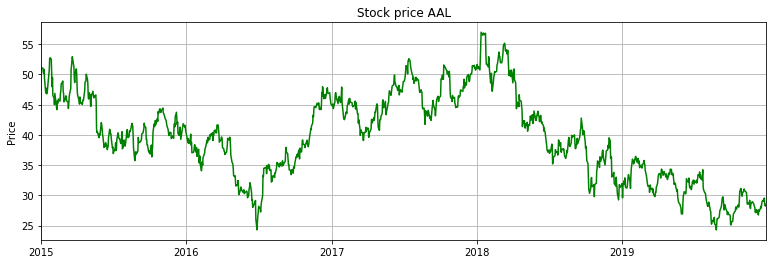

In [5]:
plt.figure(figsize=(13,4))
plt.title('Stock price '+ ticker)
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'], color='g')
plt.show()

In [6]:
y = df['Adj Close'].values.astype(float)

test_size = 21
train_set = y[:-test_size]
test_set = y[-test_size:]

In [7]:
test_set

array([27.97661209, 27.18952179, 27.27918816, 27.13970566, 27.62790108,
       27.38878441, 26.90058899, 26.76110458, 27.61793709, 27.37882042,
       27.81720161, 28.17587662, 27.89690781, 28.44488144, 28.93307877,
       29.1921196 , 29.07256317, 29.56075859, 28.33528709, 28.19580078,
       28.57440376])

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [9]:
train_norm.min()

-1.0000000000000002

In [10]:
train_norm.max()

1.0

In [11]:
train_norm.mean()

-0.04827459590507826

In [12]:
train_norm.std()

0.4333788652445345

In [13]:
train_norm = torch.FloatTensor(train_norm).view(-1)

window_size = 21


def input_data(seq,ws): 
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

train_data = input_data(train_norm,window_size)
len(train_data)  

1217

In [14]:
1259-21-21

1217

In [15]:
train_data[0]

(tensor([0.6225, 0.6387, 0.6369, 0.5883, 0.5865, 0.6242, 0.5292, 0.3878, 0.4353,
         0.3780, 0.3780, 0.4011, 0.5715, 0.6248, 0.7360, 0.7418, 0.7279, 0.5686,
         0.4481, 0.5419, 0.3588]),
 tensor([0.3380]))

In [25]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=[100, 100], output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm1 = nn.LSTM(input_size,hidden_size[0])
        
        self.lstm2 = nn.LSTM(hidden_size[0], hidden_size[1])
        
        self.linear = nn.Linear(hidden_size[1], output_size)
        
        self.hidden = (torch.zeros(1,1,self.hidden_size[0]),
                       torch.zeros(1,1,self.hidden_size[0]))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(lstm_out1.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out2.view(len(seq),-1))
        return pred[-1] 
        

In [26]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm1): LSTM(1, 100)
  (lstm2): LSTM(100, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [28]:
epochs = 100
losses= []

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size[0]),
                        torch.zeros(1,1,model.hidden_size[0]))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00125675
Epoch:  2 Loss: 0.00238039
Epoch:  3 Loss: 0.00007863
Epoch:  4 Loss: 0.00074720
Epoch:  5 Loss: 0.00053320
Epoch:  6 Loss: 0.00060003
Epoch:  7 Loss: 0.00061406
Epoch:  8 Loss: 0.00074695
Epoch:  9 Loss: 0.00063938
Epoch: 10 Loss: 0.00058799
Epoch: 11 Loss: 0.00017308
Epoch: 12 Loss: 0.00057205
Epoch: 13 Loss: 0.00004143
Epoch: 14 Loss: 0.00083867
Epoch: 15 Loss: 0.00090570
Epoch: 16 Loss: 0.00022882
Epoch: 17 Loss: 0.00059539
Epoch: 18 Loss: 0.00061097
Epoch: 19 Loss: 0.00012920
Epoch: 20 Loss: 0.00070321
Epoch: 21 Loss: 0.00012520
Epoch: 22 Loss: 0.00008317
Epoch: 23 Loss: 0.00049809
Epoch: 24 Loss: 0.00031137
Epoch: 25 Loss: 0.00003555
Epoch: 26 Loss: 0.00000127
Epoch: 27 Loss: 0.00009973
Epoch: 28 Loss: 0.00002956
Epoch: 29 Loss: 0.00015860
Epoch: 30 Loss: 0.00002863
Epoch: 31 Loss: 0.00000290
Epoch: 32 Loss: 0.00000735
Epoch: 33 Loss: 0.00002197
Epoch: 34 Loss: 0.00030861
Epoch: 35 Loss: 0.00012483
Epoch: 36 Loss: 0.00018864
Epoch: 37 Loss: 0.00004144
E

In [38]:
future = 21

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size[0]),
                        torch.zeros(1,1,model.hidden_size[0]))
        preds.append(model(seq).item())

In [39]:
preds[window_size:] 

[-0.7501307725906372,
 -0.7647325396537781,
 -0.7767221331596375,
 -0.7851208448410034,
 -0.7901618480682373,
 -0.7912419438362122,
 -0.7843548059463501,
 -0.763886034488678,
 -0.7376120686531067,
 -0.7134818434715271,
 -0.6932976841926575,
 -0.6811699271202087,
 -0.671974778175354,
 -0.6632738709449768,
 -0.6556760668754578,
 -0.6533135175704956,
 -0.655792772769928,
 -0.6607237458229065,
 -0.6664166450500488,
 -0.6716685891151428,
 -0.6758415699005127]

In [32]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[28.36756444],
       [28.1287711 ],
       [27.93269655],
       [27.7953463 ],
       [27.7129071 ],
       [27.69524351],
       [27.80787389],
       [28.14261462],
       [28.57229192],
       [28.96691106],
       [29.29699732],
       [29.49533136],
       [29.64570633],
       [29.78799861],
       [29.91225103],
       [29.95088752],
       [29.91034245],
       [29.82970266],
       [29.73660253],
       [29.65071366],
       [29.58246987]])

In [33]:
df['Adj Close'][-21:]

Date
2019-12-02    27.976612
2019-12-03    27.189522
2019-12-04    27.279188
2019-12-05    27.139706
2019-12-06    27.627901
2019-12-09    27.388784
2019-12-10    26.900589
2019-12-11    26.761105
2019-12-12    27.617937
2019-12-13    27.378820
2019-12-16    27.817202
2019-12-17    28.175877
2019-12-18    27.896908
2019-12-19    28.444881
2019-12-20    28.933079
2019-12-23    29.192120
2019-12-24    29.072563
2019-12-26    29.560759
2019-12-27    28.335287
2019-12-30    28.195801
2019-12-31    28.574404
Name: Adj Close, dtype: float64

In [34]:
df1 = pd.DataFrame(true_predictions, index=df.tail(21).index, columns=['pred'])

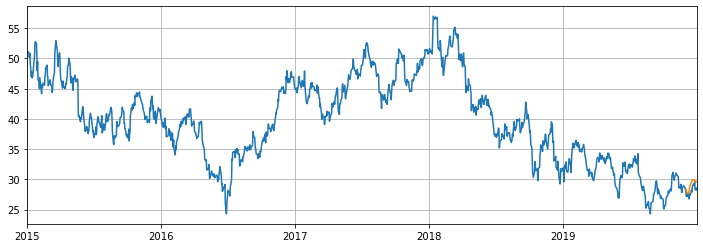

In [35]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'])
plt.plot(df1['pred'])
plt.show()

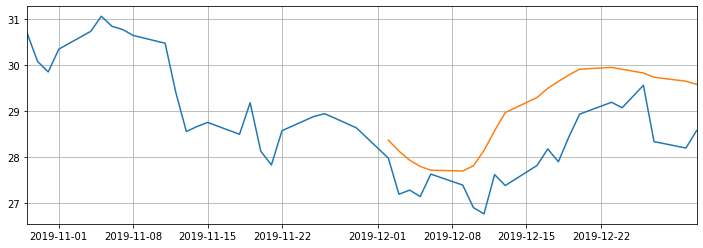

In [36]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'].iloc[-44:])
plt.plot(df1['pred'])
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(true_predictions.reshape(1, -1), df['Adj Close'][-21:].values.reshape(1, -1)))

1.076945791803734